In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import display
from tqdm import tqdm

import torch
from torch.utils.data import Dataset
from transformers import AdamW, AutoConfig, AutoTokenizer
from electra_model import ElectraForSequenceClassification

C:\Users\Administrator\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class TextClassificationDataset(Dataset):
  def __init__(self,
               file_path = "./data/wellness_text_classification.txt",
               num_label = 359,
               device = 'cuda',
               max_seq_len = 128,
               tokenizer = AutoTokenizer.from_pretrained("./pretrained_model")
               ):
    self.file_path = file_path
    self.device = device
    self.data = []
    self.tokenizer = tokenizer
    file = open(self.file_path, 'r')

    while True:
      line = file.readline()
      if not line:
        break
      datas = line.split("    ")
      index_of_words = self.tokenizer.encode(datas[0])
      token_type_ids = [0] * len(index_of_words)
      attention_mask = [1] * len(index_of_words)

      padding_length = max_seq_len - len(index_of_words)

      index_of_words += [0] * padding_length
      token_type_ids += [0] * padding_length
      attention_mask += [0] * padding_length

      label = int(datas[1][:-1])

      data = {
              'input_ids': torch.tensor(index_of_words).to(self.device),
              'token_type_ids': torch.tensor(token_type_ids).to(self.device),
              'attention_mask': torch.tensor(attention_mask).to(self.device),
              'labels': torch.tensor(label).to(self.device)
             }

      self.data.append(data)

    file.close()

  def __len__(self):
    return len(self.data)
  def __getitem__(self,index):
    item = self.data[index]
    return item

In [3]:
def train(epoch, model, optimizer, train_loader, save_step, finetuned_model, train_step = 0):
    losses = []
    train_start_index = train_step+1 if train_step != 0 else 0
    total_train_step = len(train_loader)
    model.train()

    with tqdm(total= total_train_step, desc=f"Train({epoch})") as pbar:
        pbar.update(train_step)
        for i, data in enumerate(train_loader, train_start_index):
            optimizer.zero_grad()
            inputs = {'input_ids': data['input_ids'],
                      'attention_mask': data['attention_mask'],
                      'labels': data['labels']
                      }
            outputs = model(**inputs)

            loss = outputs[0]

            losses.append(loss.item())

            loss.backward()
            optimizer.step()

            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss.item():.3f} ({np.mean(losses):.3f})")

            if i >= total_train_step or i % save_step == 0:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item(),
                    'train_step': i,
                    'total_train_step': len(train_loader)
                }, finetuned_model)

    return np.mean(losses)

In [5]:
data = f"./data/wellness_text_classification.txt"
finetuned_model = f"./finetuned_model/psychological_counseling_model.pth"
pretrained_model = "./pretrained_model"


n_epoch = 100
batch_size = 16
ctx = "cuda"
device = torch.device(ctx)
save_step = 1000
learning_rate = 5e-6 
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)

dataset = TextClassificationDataset(file_path=data, tokenizer=tokenizer, device=device)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

electra_config = AutoConfig.from_pretrained(pretrained_model)
model = ElectraForSequenceClassification.from_pretrained(pretrained_model_name_or_path=pretrained_model,
                                                            config=electra_config,
                                                            num_labels=359)
model.to(device)

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
      'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)

pre_epoch, pre_loss, train_step = 0, 0, 0
if os.path.isfile(finetuned_model):
    checkpoint = torch.load(finetuned_model, map_location=device)
    pre_epoch = checkpoint['epoch']
    pre_loss = checkpoint['loss']
    train_step =  checkpoint['train_step']
    total_train_step =  checkpoint['total_train_step']

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    print(f"load pretrain from: {finetuned_model}, epoch={pre_epoch}, loss={pre_loss}")

losses = []
offset = pre_epoch
for step in range(n_epoch):
    epoch = step + offset
    loss = train( epoch, model, optimizer, train_loader, save_step, finetuned_model, train_step)
    losses.append(loss)
    if loss <= 0.02: break

Some weights of the model checkpoint at ./pretrained_model were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at ./pretrained_model and are newly initialized: ['classifier.out_proj.weight', 'classifier.d

KeyboardInterrupt: 

,loss
0,5.705697
1,5.484714
2,5.322536
3,5.090330
4,4.845945
...,...
62,0.023602
63,0.020716
64,0.027723
65,0.023979


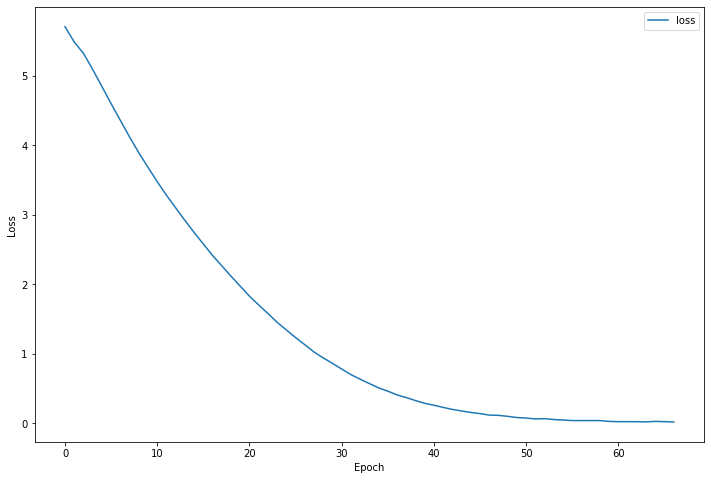

<Figure size 432x288 with 0 Axes>

In [5]:
data = {"loss": losses}
df = pd.DataFrame(data)

display(df)
plt.figure(figsize=[12, 8])
plt.plot(losses, label="loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
plt.savefig('./Epoch_Loss_data.png')